In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pdb

### Step1:  Sample code settings

In [21]:
img = np.ones((300, 400), np.uint8)*255
dets = np.array([
    [83,54,165,163,0.8], 
    [67,48,118,132,0.5], 
    [91,38,192,171,0.6]], np.float)

# removing confidence term
boxes = dets[:, :-1]

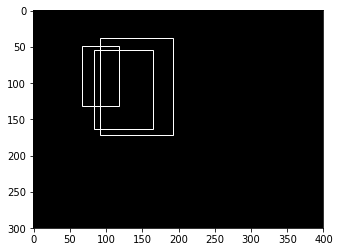

In [82]:
def show_boxes(img, boxes):
    plt.imshow(img, 'gray')
    for box in boxes:
        plt.gca().add_patch(plt.Rectangle((box[0],box[1]), box[2]-box[0],box[3]-box[1], fill=False, color='w'))
    plt.show()
show_boxes(img, boxes)

### Step2: Naive NMS

* NMS算法简单的说，就是先将所有boxes按照某个标准（如confidence大小)进行优先级排序，然后按优先级从高到低的顺序依次取box并与其他box逐一比较iou，若iou大于阈值则抑制，否则保留。　　
  
  
* 一个误区是认为NMS必须先将boxes按照confidence排序。其实并非如此。按照什么标准排优先级都可以抑制掉大部分boxes，唯一的区别在于，不同的排序标准会导致NMS之后倾向于留下不同的box。比如下面的代码按照每个box的最小横坐标，即x1s进行排序，x1越小的优先权越大。那么当我们把阈值调的很低时，剩下的唯一一个box就是最左边那个box。  
  
  
* 注意: np.argsort默认是按照从小到大的顺序排列,且第二个参数应为索引下标

In [129]:
def nms(boxes, thresh=0.3):
    x1s, x2s = boxes[:, 0], boxes[:, 2]
    y1s, y2s = boxes[:, 1], boxes[:, 3]
    
    areas = (x2s-x1s+1) * (y2s-y1s+1)
    idxs = np.argsort(x1s)
    
    pick = []
    
    #只要idxs中还有元素，就继续
    while len(idxs)>0:
        #这里的idxs是按照某种优先级对boxes进行排序。正常情况下优先级是confidence。
        #该段代码先以box的xmin为排序指标
        first = idxs[0]
        #注意: 优先权最高的box必然会被pick
        pick.append(first)
        
        #即使所有其他box都未被抑制，当前loop的基准box(first)也会被从idx中去除
        suppress = [0]

        #以first为基准box，与剩下的box逐一比较iou
        for j, curr in enumerate(idxs[1:]):
            j = j+1 #0号box为base，应跳过
            x1_inter = max(x1s[first], x1s[curr])
            y1_inter = max(y1s[first], y1s[curr])
            x2_inter = min(x2s[first], x2s[curr])
            y2_inter = min(y2s[first], y2s[curr])
            intersection = (y2_inter-y1_inter+1) * (x2_inter-x1_inter+1)
            union = areas[first] + areas[curr] - intersection
            iou = intersection / union
            if iou > thresh:
                suppress.append(j)
                
        #np.delete第二个参数是索引下标
        idxs = np.delete(idxs, suppress)
    return boxes[pick]

In [130]:
nms(boxes, 0.1)

array([[ 67.,  48., 118., 132.]])

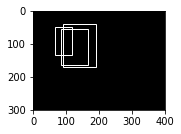

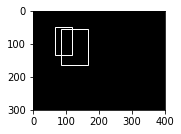

In [131]:
plt.subplot(211)
show_boxes(img, boxes)
plt.subplot(212)
show_boxes(img, nms(boxes,0.3))

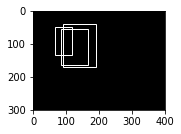

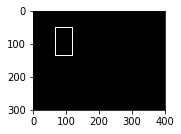

In [132]:
plt.subplot(211)
show_boxes(img, boxes)
plt.subplot(212)
show_boxes(img, nms(boxes,0.1))

* 接下来的版本更加常用，因为其排优先级的标准是每个box的confidence。

In [133]:
def show_dets(img, dets):
    plt.imshow(img, 'gray')
    for det in dets:
        plt.gca().add_patch(plt.Rectangle((det[0],det[1]), 
                                          det[2]-det[0],det[3]-det[1], fill=False, color='w'))
        plt.text(det[0], det[1], str(det[-1]), color='r', fontsize=8)
    plt.show()


def nms_v2(dets, thresh=0.3):
    x1s, x2s = dets[:, 0], dets[:, 2]
    y1s, y2s = dets[:, 1], dets[:, 3]
    confs = dets[:, 4]
    
    areas = (x2s-x1s+1) * (y2s-y1s+1)
    idxs = np.argsort(confs)[::-1]
    
    pick = []
    
    #只要idxs中还有元素，就继续
    while len(idxs)>0:
        first = idxs[0]
        #注意: 优先权最高的box必然会被pick
        pick.append(first)
        
        #即使所有其他box都未被抑制，当前loop的基准box(first)也会被从idx中去除
        suppress = [0]

        #以first为基准box，与剩下的box逐一比较iou
        for j, curr in enumerate(idxs[1:]):
            j = j+1 #0号box为base，应跳过
            x1_inter = max(x1s[first], x1s[curr])
            y1_inter = max(y1s[first], y1s[curr])
            x2_inter = min(x2s[first], x2s[curr])
            y2_inter = min(y2s[first], y2s[curr])
            intersection = (y2_inter-y1_inter+1) * (x2_inter-x1_inter+1)
            union = areas[first] + areas[curr] - intersection
            iou = intersection / union
            if iou > thresh:
                suppress.append(j)
                
        #np.delete第二个参数是索引下标
        idxs = np.delete(idxs, suppress)
    return dets[pick]

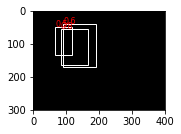

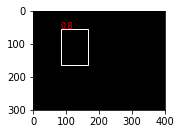

In [134]:
plt.subplot(211)
show_dets(img, dets)
plt.subplot(212)
show_dets(img, nms_v2(dets,0.1))

* 可以看出，如果thresh设的很小，这次剩下的box会倾向于confidence高的box。  
  

* 此外，上面的nms算法实现比较naive，使用了双层循环，其实速度比较慢:

In [258]:
%%time
for _ in range(100000):
    _ = nms_v2(dets,0.3)

CPU times: user 5.86 s, sys: 130 ms, total: 5.99 s
Wall time: 5.85 s


### Step3: 优化——去掉内层循环

In [236]:
def nms_v3(dets, thresh=0.3):
    x1s, x2s = dets[:, 0], dets[:, 2]
    y1s, y2s = dets[:, 1], dets[:, 3]
    confs = dets[:, 4]
    
    areas = (x2s-x1s+1) * (y2s-y1s+1)
    idxs = np.argsort(confs)[::-1]
    
    pick = []
    
    #只要idxs中还有元素，就继续
    while len(idxs)>0:
        first = idxs[0]
        #注意: 优先权最高的box必然会被pick
        pick.append(first)
        if len(idxs)==1:
            return dets[pick]
        
        suppress = [0]

        #比较当前base box（１个）和剩下所有boxes（n-1个），得到n-1维向量
        x1_inter = np.maximum(x1s[first], x1s[idxs[1:]])
        y1_inter = np.maximum(y1s[first], y1s[idxs[1:]])
        x2_inter = np.minimum(x2s[first], x2s[idxs[1:]])
        y2_inter = np.minimum(y2s[first], y2s[idxs[1:]])

        intersections = (y2_inter-y1_inter+1) * (x2_inter-x1_inter+1)
        unions = areas[first] + areas[idxs[1:]] - intersections
        ious = intersections / unions
        
        #注意np.where得到的下标是从0开始计数的，而下标0是base box，即first
        suppress += (np.where(ious>thresh)[0] + 1).tolist()
        idxs = np.delete(idxs, suppress)
        #idxs = np.delete(idxs, np.concatenate((np.where(ious>thresh)[0] + 1, [0])))
        
    return dets[pick]

* Note: You have to use the np.maximum  and np.minimum  functions here — they allow you to mix scalars and vectors. The np.max  and np.min  functions do not, and if you use them, you will find yourself with some pretty fierce bugs to find and fix. 

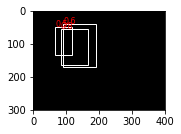

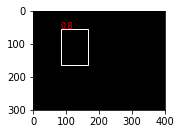

In [237]:
plt.subplot(211)
show_dets(img, dets)
plt.subplot(212)
show_dets(img, nms_v3(dets,0.1))

* 比较下优化之后的时间

In [257]:
%%time
for _ in range(100000):
    _ = nms_v3(dets,0.3)

CPU times: user 4.93 s, sys: 147 ms, total: 5.07 s
Wall time: 4.9 s


* 用到了numpy的向量化并去掉一个循环，但是速度提高没有想象中的多...不知道是哪里出了问题？应该不会是if占用很多时间，可能是tolist?

### 参考：　　
* https://www.pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python/  
* https://blog.csdn.net/hzhj2007/article/details/79801307　　
* https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/

### 实验区

In [45]:
t = np.arange(8)

In [140]:
x1s, x2s = boxes[:, 0], boxes[:, 2]
y1s, y2s = boxes[:, 1], boxes[:, 3]

areas = (x2s-x1s+1) * (y2s-y1s+1)
idxs = np.argsort(y1s)

In [142]:
i = 0
last = len(idxs) - 1
np.maximum(x1s[i], x1s[idxs[:last]])

array([91., 83.])

In [144]:
x1s[i]

83.0

In [145]:
x1s[idxs[:last]]

array([91., 67.])

* np.maximumu等函数的参数如果为空矩阵：

In [227]:
np.maximum(np.array([12]).tolist(), np.array([]).tolist())

array([], dtype=float64)